## P2 IN:  Clustering --- Ignacio Garach Vélez

In [1]:
# -*- coding: utf-8 -*-
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import cluster
import plotly.express as px
import warnings 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor
import seaborn as sns
from scipy.cluster import hierarchy
from scipy import stats
sns.set(font_scale=2)

In [2]:
datos = pd.read_csv('Fire-Incidents_v2.csv')

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)


Incident_Ward 33


In [3]:
from scipy import stats
m = stats.mode(datos['Incident_Ward'])
datos['Incident_Ward'].fillna(m[0][0], inplace=True)

In [4]:
for df in datos.columns:
    print(df)

Area_of_Origin
Business_Impact
Civilian_Casualties
Count_of_Persons_Rescued
Estimated_Dollar_Loss
Estimated_Number_Of_Persons_Displaced
Ext_agent_app_or_defer_time
Extent_Of_Fire
Fire_Alarm_System_Impact_on_Evacuation
Fire_Alarm_System_Operation
Fire_Alarm_System_Presence
Fire_Under_Control_Time
Ignition_Source
Incident_Station_Area
Incident_Ward
Last_TFS_Unit_Clear_Time
Latitude
Longitude
Material_First_Ignited
Method_Of_Fire_Control
Possible_Cause
Property_Use
Smoke_Alarm_at_Fire_Origin_Alarm_Failure
Smoke_Alarm_at_Fire_Origin_Alarm_Type
Status_of_Fire_On_Arrival
TFS_Alarm_Time
TFS_Arrival_Time
Arrival_Time
Day_Of_Week
Month


## Breve análisis exploratorio

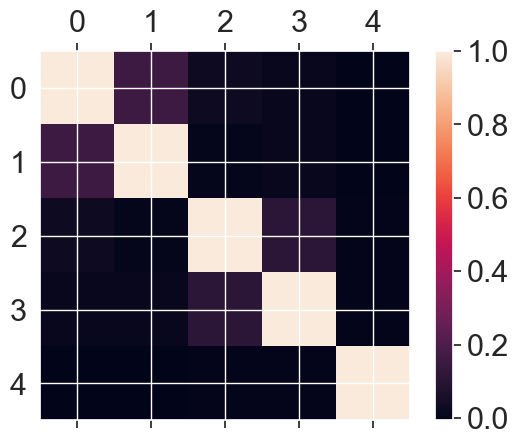

In [5]:
exp=datos.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
exp = exp[usadas]
correlations = exp.corr(method='pearson')
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(correlations)
figure.colorbar(caxes)

In [6]:
correlations

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
Muertos,1.000000,0.156616,0.032549,0.013654,-0.006609
Rescatados,0.156616,1.000000,0.007879,0.013145,-0.005125
Desplazados,0.032549,0.007879,1.000000,0.115060,0.003529
Coste Material,0.013654,0.013145,0.115060,1.000000,0.004089
Tiempo,-0.006609,-0.005125,0.003529,0.004089,1.000000


## Caso de estudio 1: Llegada tardía

In [7]:
len(datos[datos['Arrival_Time']>360])

2226

In [8]:
np.percentile(datos['Arrival_Time'], [25, 50, 80])

array([245., 291., 360.])

In [9]:
datos['Arrival_Time'].mean()

300.15864098448367

In [10]:
caso1 = datos.loc[datos['Arrival_Time']>360]
caso1=caso1.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso1 = caso1[usadas]
caso1

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
6,0,11,13,30000,375
22,0,4,3,15600,393
25,0,4,0,5000,413
28,0,4,0,12000,372
29,2,4,50,150000,388
...,...,...,...,...,...
11153,0,0,0,0,414
11178,0,0,0,25,379
11191,0,0,0,500,372
11207,1,0,0,10,367


In [11]:
caso1c = datos.loc[datos['Arrival_Time']<=360]
caso1c=caso1c.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso1c = caso1c[usadas]
caso1c

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
0,0,86,0,3000,273
1,0,28,28,50000,311
2,1,16,130,1000000,222
3,0,12,14,1000000,177
4,8,11,2,125000,304
...,...,...,...,...,...
11208,0,0,25,0,333
11209,0,0,0,0,210
11211,0,0,0,0,274
11212,6,0,1,100000,275


In [12]:
s1 = MinMaxScaler()
s1c = MinMaxScaler()
caso1 = s1.fit_transform(caso1)
caso1c = s1c.fit_transform(caso1c)

## Caso de estudio 2: Presencia de Alarma de incendios

In [13]:
datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type'].unique()

array(['Hardwired (standalone)', 'Interconnected', 'Type undetermined',
       'Not applicable - no smoke alarm or presence undetermined',
       'Battery operated', 'Wireless'], dtype=object)

In [14]:
datos[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Wireless'].count()[0]

24

In [15]:
datos[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Battery operated'].count()[0]

2380

In [16]:
datos[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Not applicable - no smoke alarm or presence undetermined'].count()[0]

2569

In [17]:
datos[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Hardwired (standalone)'].count()[0]

2276

In [18]:
datos[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Interconnected'].count()[0]

2066

In [19]:
caso2 = datos.loc[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Not applicable - no smoke alarm or presence undetermined']
caso2=caso2.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso2 = caso2[usadas]
caso2

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
5,0,11,0,100000,266
14,1,6,7,80000,231
15,6,6,30,100000,146
17,0,5,150,0,292
18,0,5,6,400000,281
...,...,...,...,...,...
11108,0,0,0,1000,359
11124,0,0,0,0,292
11158,0,0,1,30000,175
11203,0,0,0,0,269


In [20]:
caso2c = datos.loc[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']!='Not applicable - no smoke alarm or presence undetermined']
caso2c=caso2c.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso2c = caso2c[usadas]
caso2c

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
0,0,86,0,3000,273
1,0,28,28,50000,311
2,1,16,130,1000000,222
3,0,12,14,1000000,177
4,8,11,2,125000,304
...,...,...,...,...,...
11209,0,0,0,0,210
11210,0,0,0,1000,374
11211,0,0,0,0,274
11212,6,0,1,100000,275


In [21]:
s2 = MinMaxScaler()
s2c = MinMaxScaler()
caso2 = s2.fit_transform(caso2)
caso2c = s2c.fit_transform(caso2c)

## Caso de estudio 3: Fines de semana

In [22]:
caso3 = datos.loc[(datos['Day_Of_Week']=='Saturday') | (datos['Day_Of_Week']=='Sunday')]
caso3=caso3.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso3 = caso3[usadas]
caso3

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
1,0,28,28,50000,311
4,8,11,2,125000,304
6,0,11,13,30000,375
12,0,7,4,220000,236
14,1,6,7,80000,231
...,...,...,...,...,...
11207,1,0,0,10,367
11210,0,0,0,1000,374
11211,0,0,0,0,274
11212,6,0,1,100000,275


In [23]:
caso3c = datos.loc[(datos['Day_Of_Week']!='Saturday') & (datos['Day_Of_Week']!='Sunday')]
caso3c=caso3c.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
caso3c = caso3c[usadas]
caso3c

,Muertos,Rescatados,Desplazados,Coste Material,Tiempo
0,0,86,0,3000,273
2,1,16,130,1000000,222
3,0,12,14,1000000,177
5,0,11,0,100000,266
7,8,11,40,50000,246
...,...,...,...,...,...
11202,0,0,0,700,270
11204,0,0,0,2000,50
11205,0,0,0,2000,220
11208,0,0,25,0,333


In [24]:
s3 = MinMaxScaler()
s3c = MinMaxScaler()
caso3 = s3.fit_transform(caso3)
caso3c = s3c.fit_transform(caso3c)

## Algoritmos

### K-Means: Análisis paramétrico

In [25]:
k_means = KMeans(init='k-means++', n_clusters=2, n_init=5, random_state=2020)

In [145]:
X_normal = caso1

In [146]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.01 segundos, Calinski-Harabasz Index: 4179.519, Silhouette Coefficient: 0.95524
Tamaño de cada cluster:
0:  2200 (98.83%)
1:    26 ( 1.17%)
 Números de Clusters 3: 0.01 segundos, Calinski-Harabasz Index: 4526.707, Silhouette Coefficient: 0.88939
Tamaño de cada cluster:
0:   179 ( 8.04%)
1:  2021 (90.79%)
2:    26 ( 1.17%)
 Números de Clusters 4: 0.01 segundos, Calinski-Harabasz Index: 3899.385, Silhouette Coefficient: 0.89105
Tamaño de cada cluster:
0:  2021 (90.79%)
1:    26 ( 1.17%)
2:   167 ( 7.50%)
3:    12 ( 0.54%)
 Números de Clusters 5: 0.01 segundos, Calinski-Harabasz Index: 3698.470, Silhouette Coefficient: 0.89299
Tamaño de cada cluster:
0:  2020 (90.75%)
1:    26 ( 1.17%)
2:   160 ( 7.19%)
3:    19 ( 0.85%)
4:     1 ( 0.04%)
 Números de Clusters 6: 0.02 segundos, Calinski-Harabasz Index: 3783.746, Silhouette Coefficient: 0.89835
Tamaño de cada cluster:
0:  2016 (90.57%)
1:    26 ( 1.17%)
2:   166 ( 7.46%)
3:     1 ( 0.04%)
4:    11 ( 0.49%)
5:     6

----- Ejecutando k-MeansTamaño de cada cluster:
0:  2021 (90.79%)
2:   179 ( 8.04%)
1:    26 ( 1.17%)
---------- Heatmap de centroides...


<Figure size 640x480 with 0 Axes>

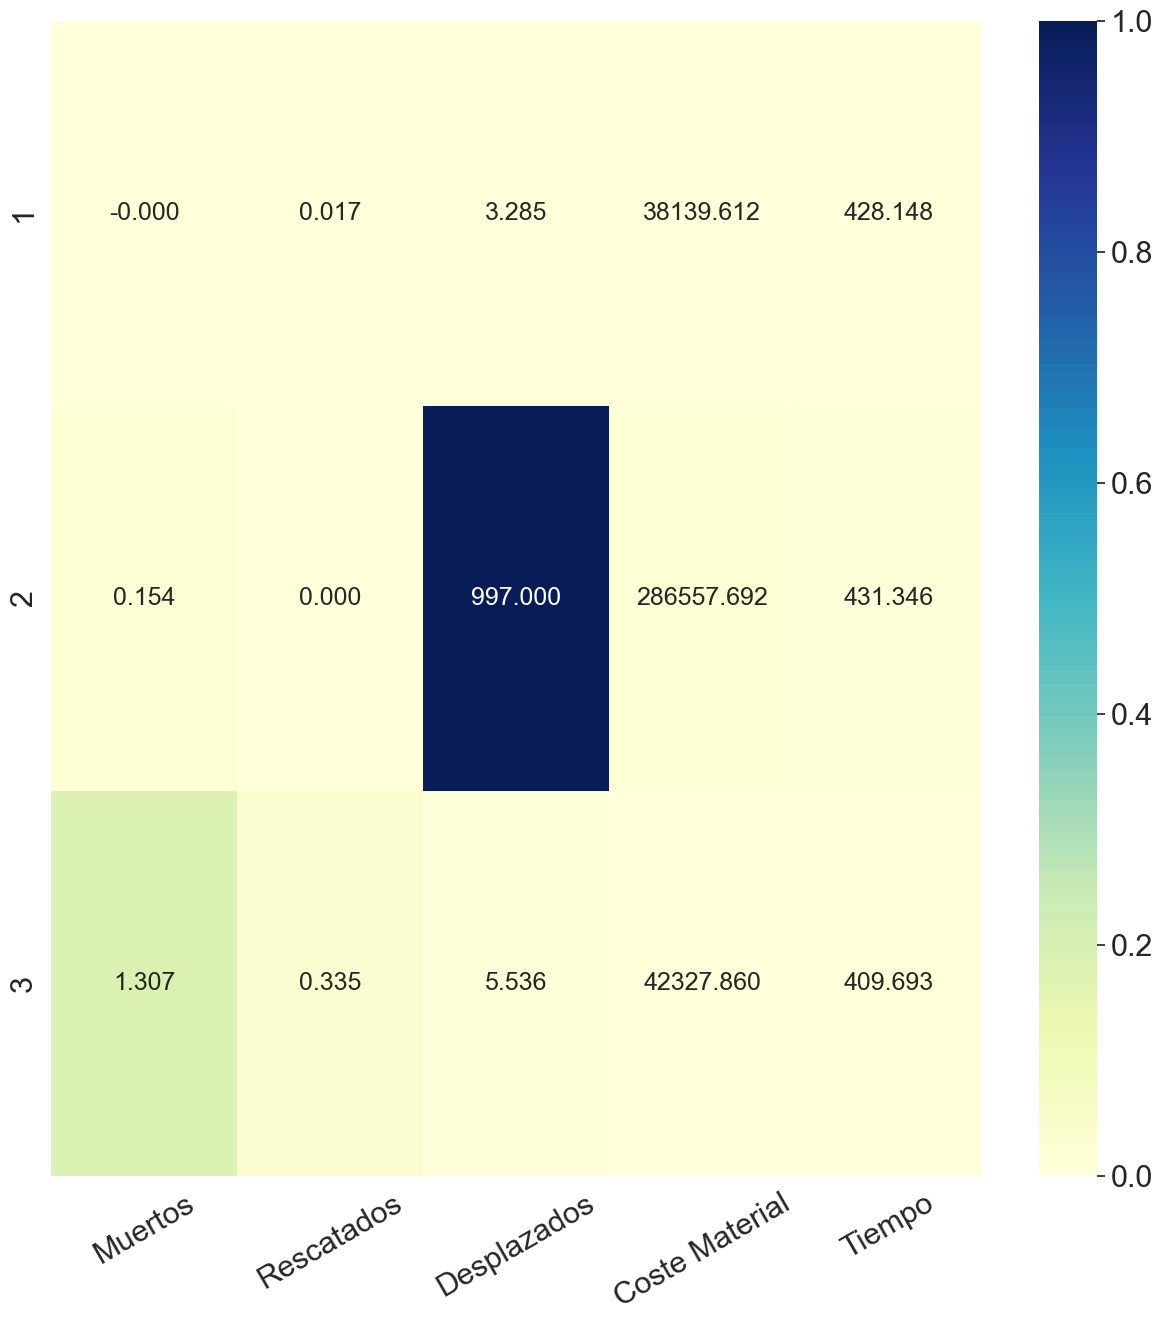

In [160]:
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

X = datos.loc[datos['Arrival_Time']>360]
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]

X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=3, n_init=5, random_state=2020)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

#'''
print("---------- Heatmap de centroides...")
plt.figure()
centers.index += 1
plt.figure()
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
plt.xticks(rotation=30)
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)

In [34]:
X_normal = caso1c

In [35]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.03 segundos, Calinski-Harabasz Index: 6272.099, Silhouette Coefficient: 0.50878
Tamaño de cada cluster:
0:  5201 (57.87%)
1:  3787 (42.13%)
 Números de Clusters 3: 0.04 segundos, Calinski-Harabasz Index: 12974.105, Silhouette Coefficient: 0.54989
Tamaño de cada cluster:
0:  3802 (42.30%)
1:  5050 (56.19%)
2:   136 ( 1.51%)
 Números de Clusters 4: 0.04 segundos, Calinski-Harabasz Index: 16588.023, Silhouette Coefficient: 0.51913
Tamaño de cada cluster:
0:  3700 (41.17%)
1:  3435 (38.22%)
2:  1716 (19.09%)
3:   137 ( 1.52%)
 Números de Clusters 5: 0.07 segundos, Calinski-Harabasz Index: 17581.506, Silhouette Coefficient: 0.49296
Tamaño de cada cluster:
0:  2257 (25.11%)
1:  2679 (29.81%)
2:   136 ( 1.51%)
3:  3088 (34.36%)
4:   828 ( 9.21%)
 Números de Clusters 6: 0.06 segundos, Calinski-Harabasz Index: 17763.136, Silhouette Coefficient: 0.47399
Tamaño de cada cluster:
0:  1957 (21.77%)
1:   437 ( 4.86%)
2:  2460 (27.37%)
3:   136 ( 1.51%)
4:  1582 (17.60%)
5:  

----- Ejecutando k-MeansTamaño de cada cluster:
2:  3088 (34.36%)
0:  2679 (29.81%)
4:  2257 (25.11%)
1:   828 ( 9.21%)
3:   136 ( 1.51%)
---------- Heatmap de centroides...


<Figure size 640x480 with 0 Axes>

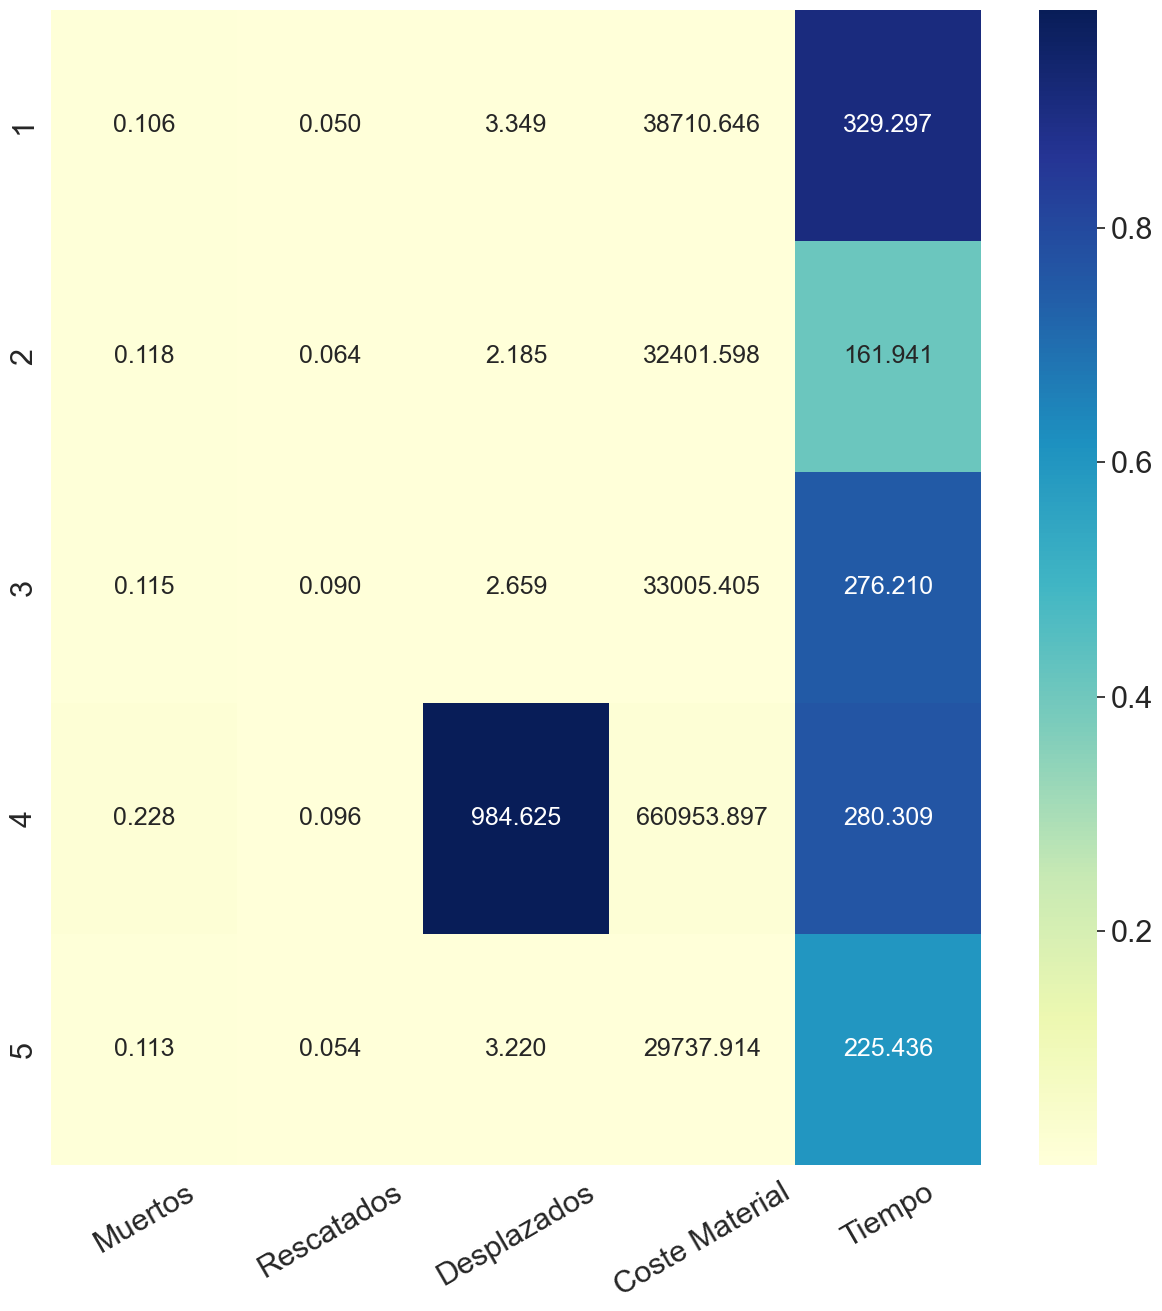

In [161]:
X = datos.loc[datos['Arrival_Time']<=360]
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]

X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=5, n_init=5, random_state=2020)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

#'''
print("---------- Heatmap de centroides...")
plt.figure()
centers.index += 1
plt.figure()
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
plt.xticks(rotation=30)
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)

In [36]:
X_normal = caso2

In [37]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.02 segundos, Calinski-Harabasz Index: 3699.485, Silhouette Coefficient: 0.88618
Tamaño de cada cluster:
0:  2518 (98.01%)
1:    51 ( 1.99%)
 Números de Clusters 3: 0.03 segundos, Calinski-Harabasz Index: 3149.336, Silhouette Coefficient: 0.45803
Tamaño de cada cluster:
0:    51 ( 1.99%)
1:   902 (35.11%)
2:  1616 (62.90%)
 Números de Clusters 4: 0.02 segundos, Calinski-Harabasz Index: 3162.097, Silhouette Coefficient: 0.51542
Tamaño de cada cluster:
0:  1512 (58.86%)
1:    51 ( 1.99%)
2:   864 (33.63%)
3:   142 ( 5.53%)
 Números de Clusters 5: 0.03 segundos, Calinski-Harabasz Index: 2957.438, Silhouette Coefficient: 0.47616
Tamaño de cada cluster:
0:  1096 (42.66%)
1:    51 ( 1.99%)
2:   141 ( 5.49%)
3:   921 (35.85%)
4:   360 (14.01%)
 Números de Clusters 6: 0.03 segundos, Calinski-Harabasz Index: 2823.902, Silhouette Coefficient: 0.49351
Tamaño de cada cluster:
0:  1013 (39.43%)
1:    51 ( 1.99%)
2:  1080 (42.04%)
3:   281 (10.94%)
4:    26 ( 1.01%)
5:   118

----- Ejecutando k-MeansTamaño de cada cluster:
0:  2518 (98.01%)
1:    51 ( 1.99%)
---------- Heatmap de centroides...


<Figure size 640x480 with 0 Axes>

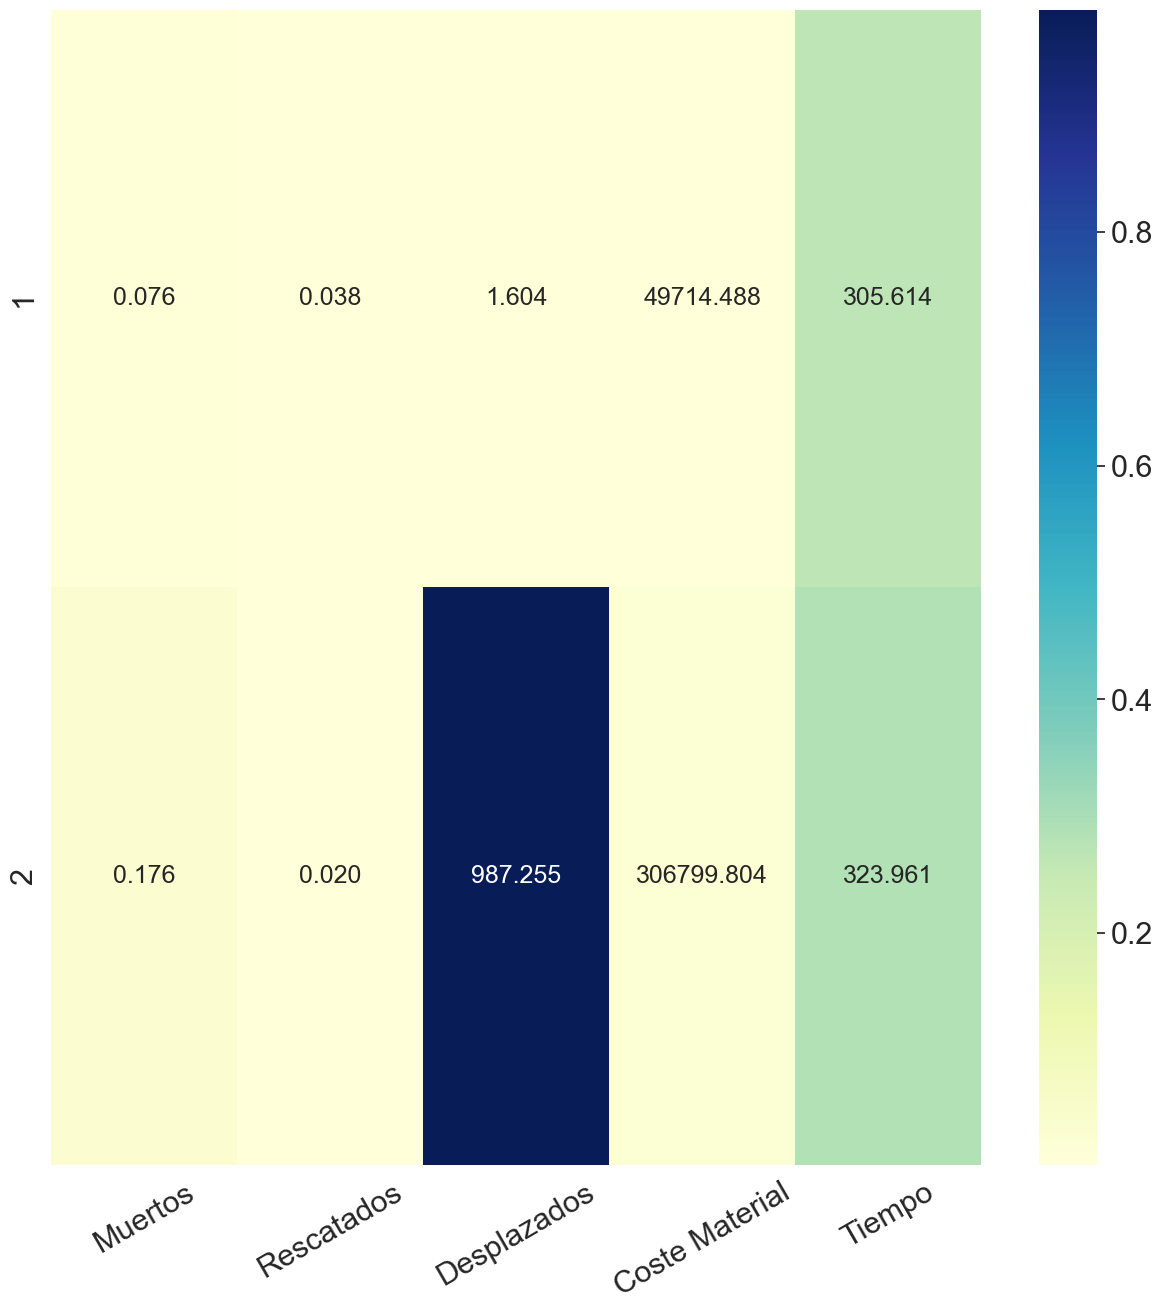

In [162]:
X = datos.loc[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']=='Not applicable - no smoke alarm or presence undetermined']
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]

X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=2, n_init=5, random_state=2020)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

#'''
print("---------- Heatmap de centroides...")
plt.figure()
centers.index += 1
plt.figure()
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
plt.xticks(rotation=30)
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)

In [38]:
X_normal = caso2c

In [39]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.01 segundos, Calinski-Harabasz Index: 57022.543, Silhouette Coefficient: 0.97294
Tamaño de cada cluster:
0:  8530 (98.67%)
1:   115 ( 1.33%)
 Números de Clusters 3: 0.02 segundos, Calinski-Harabasz Index: 45579.936, Silhouette Coefficient: 0.85444
Tamaño de cada cluster:
0:  7742 (89.55%)
1:   115 ( 1.33%)
2:   788 ( 9.12%)
 Números de Clusters 4: 0.02 segundos, Calinski-Harabasz Index: 39190.181, Silhouette Coefficient: 0.86307
Tamaño de cada cluster:
0:  7716 (89.25%)
1:   110 ( 1.27%)
2:   786 ( 9.09%)
3:    33 ( 0.38%)
 Números de Clusters 5: 0.02 segundos, Calinski-Harabasz Index: 37315.896, Silhouette Coefficient: 0.87042
Tamaño de cada cluster:
0:  7660 (88.61%)
1:   110 ( 1.27%)
2:    55 ( 0.64%)
3:   729 ( 8.43%)
4:    91 ( 1.05%)
 Números de Clusters 6: 0.02 segundos, Calinski-Harabasz Index: 35178.408, Silhouette Coefficient: 0.86484
Tamaño de cada cluster:
0:  7714 (89.23%)
1:   110 ( 1.27%)
2:    35 ( 0.40%)
3:   730 ( 8.44%)
4:    55 ( 0.64%)
5: 

----- Ejecutando k-MeansTamaño de cada cluster:
0:  8530 (98.67%)
1:   115 ( 1.33%)
---------- Heatmap de centroides...


<Figure size 640x480 with 0 Axes>

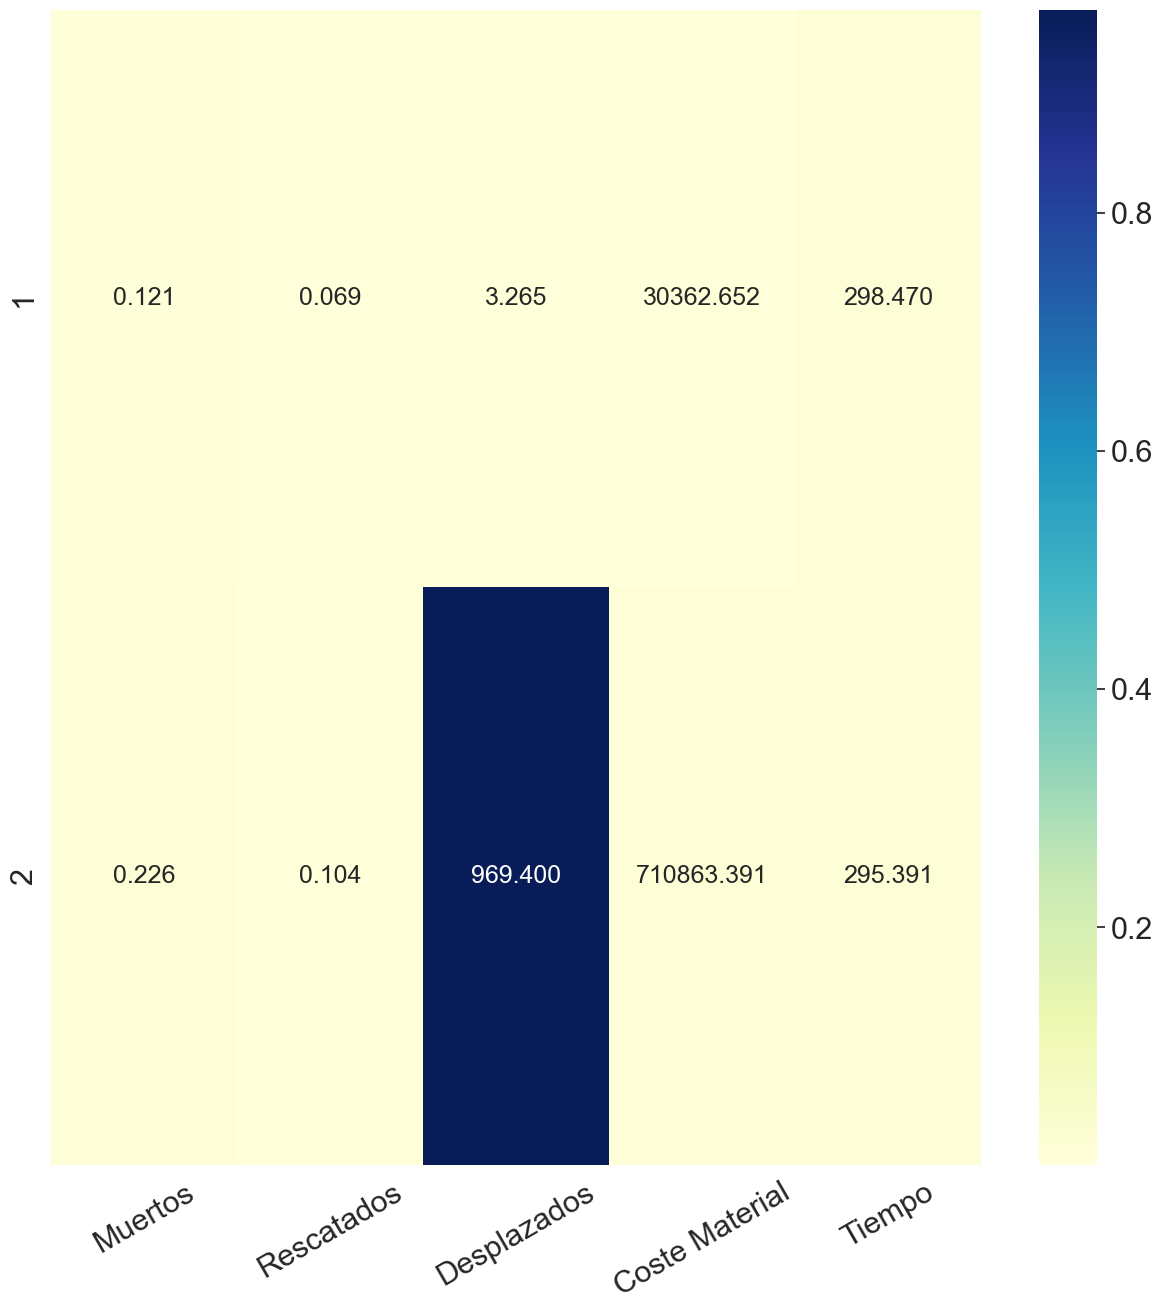

In [163]:
X = datos.loc[datos['Smoke_Alarm_at_Fire_Origin_Alarm_Type']!='Not applicable - no smoke alarm or presence undetermined']
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]

X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=2, n_init=5, random_state=2020)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

#'''
print("---------- Heatmap de centroides...")
plt.figure()
centers.index += 1
plt.figure()
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
plt.xticks(rotation=30)
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)

In [41]:
X_normal = caso3

In [42]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.02 segundos, Calinski-Harabasz Index: 2656.300, Silhouette Coefficient: 0.86970
Tamaño de cada cluster:
0:  3266 (98.79%)
1:    40 ( 1.21%)
 Números de Clusters 3: 0.02 segundos, Calinski-Harabasz Index: 3407.201, Silhouette Coefficient: 0.47409
Tamaño de cada cluster:
0:  1328 (40.17%)
1:    40 ( 1.21%)
2:  1938 (58.62%)
 Números de Clusters 4: 0.03 segundos, Calinski-Harabasz Index: 3128.032, Silhouette Coefficient: 0.50540
Tamaño de cada cluster:
0:   237 ( 7.17%)
1:  1248 (37.75%)
2:  1782 (53.90%)
3:    39 ( 1.18%)
 Números de Clusters 5: 0.03 segundos, Calinski-Harabasz Index: 3286.445, Silhouette Coefficient: 0.45891
Tamaño de cada cluster:
0:  1054 (31.88%)
1:   600 (18.15%)
2:    39 ( 1.18%)
3:  1378 (41.68%)
4:   235 ( 7.11%)
 Números de Clusters 6: 0.09 segundos, Calinski-Harabasz Index: 3186.511, Silhouette Coefficient: 0.45307
Tamaño de cada cluster:
0:  1179 (35.66%)
1:    39 ( 1.18%)
2:   308 ( 9.32%)
3:   616 (18.63%)
4:   934 (28.25%)
5:   230

Tamaño de cada cluster:
0:  3260 (98.61%)
1:    40 ( 1.21%)
2:     4 ( 0.12%)
3:     1 ( 0.03%)
4:     1 ( 0.03%)


C:\Users\ignan\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 5.

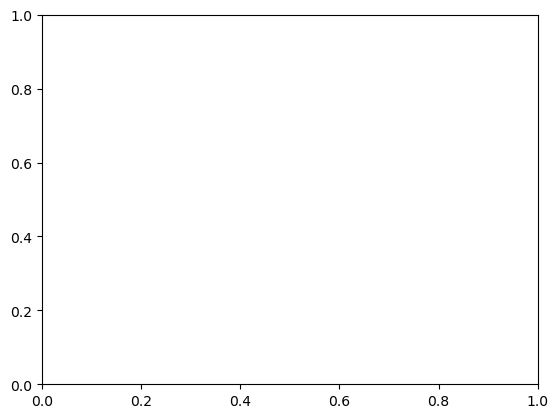

In [188]:
X = datos.loc[(datos['Day_Of_Week']=='Saturday') | (datos['Day_Of_Week']=='Sunday')]
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]
X_normal = X.apply(norm_to_zero_one)
k_means = MeanShift(bandwidth=0.3)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())


mds = MDS(random_state=123456)
centers_mds = mds.fit_transform(centers)
colors = sns.color_palette(palette='Paired', n_colors=3, desat=None)
plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size**1.6, alpha=0.75, c=colors) # mejor si se usa weights de 'DB090' para size
for i in range(k):
    plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
xl,xr = plt.xlim()
yl,yr = plt.ylim()
plt.xlim(xl-(xr-xl)*0.13,xr+(xr-xl)*0.13)
plt.ylim(yl-(yr-yl)*0.13,yr+(yr-yl)*0.13)
plt.xticks([])
plt.yticks([])
fig.set_size_inches(15,15)

In [43]:
X_normal = caso3c

In [44]:
for ncs in range(2, 9):
    k_means = KMeans(init='k-means++', n_clusters=ncs, n_init=5, random_state=2020)
    # Tiempo
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.01 segundos, Calinski-Harabasz Index: 62763.863, Silhouette Coefficient: 0.97376
Tamaño de cada cluster:
0:  7782 (98.41%)
1:   126 ( 1.59%)
 Números de Clusters 3: 0.01 segundos, Calinski-Harabasz Index: 48004.292, Silhouette Coefficient: 0.85679
Tamaño de cada cluster:
0:  7128 (90.14%)
1:   126 ( 1.59%)
2:   654 ( 8.27%)
 Números de Clusters 4: 0.02 segundos, Calinski-Harabasz Index: 41918.525, Silhouette Coefficient: 0.86516
Tamaño de cada cluster:
0:  7105 (89.85%)
1:   121 ( 1.53%)
2:   651 ( 8.23%)
3:    31 ( 0.39%)
 Números de Clusters 5: 0.03 segundos, Calinski-Harabasz Index: 38469.286, Silhouette Coefficient: 0.87112
Tamaño de cada cluster:
0:  7052 (89.18%)
1:   121 ( 1.53%)
2:   603 ( 7.63%)
3:    86 ( 1.09%)
4:    46 ( 0.58%)
 Números de Clusters 6: 0.03 segundos, Calinski-Harabasz Index: 36413.095, Silhouette Coefficient: 0.85702
Tamaño de cada cluster:
0:  7104 (89.83%)
1:   120 ( 1.52%)
2:   126 ( 1.59%)
3:    31 ( 0.39%)
4:   526 ( 6.65%)
5: 

----- Ejecutando k-MeansTamaño de cada cluster:
0:  7782 (98.41%)
1:   126 ( 1.59%)
---------- Heatmap de centroides...


<Figure size 640x480 with 0 Axes>

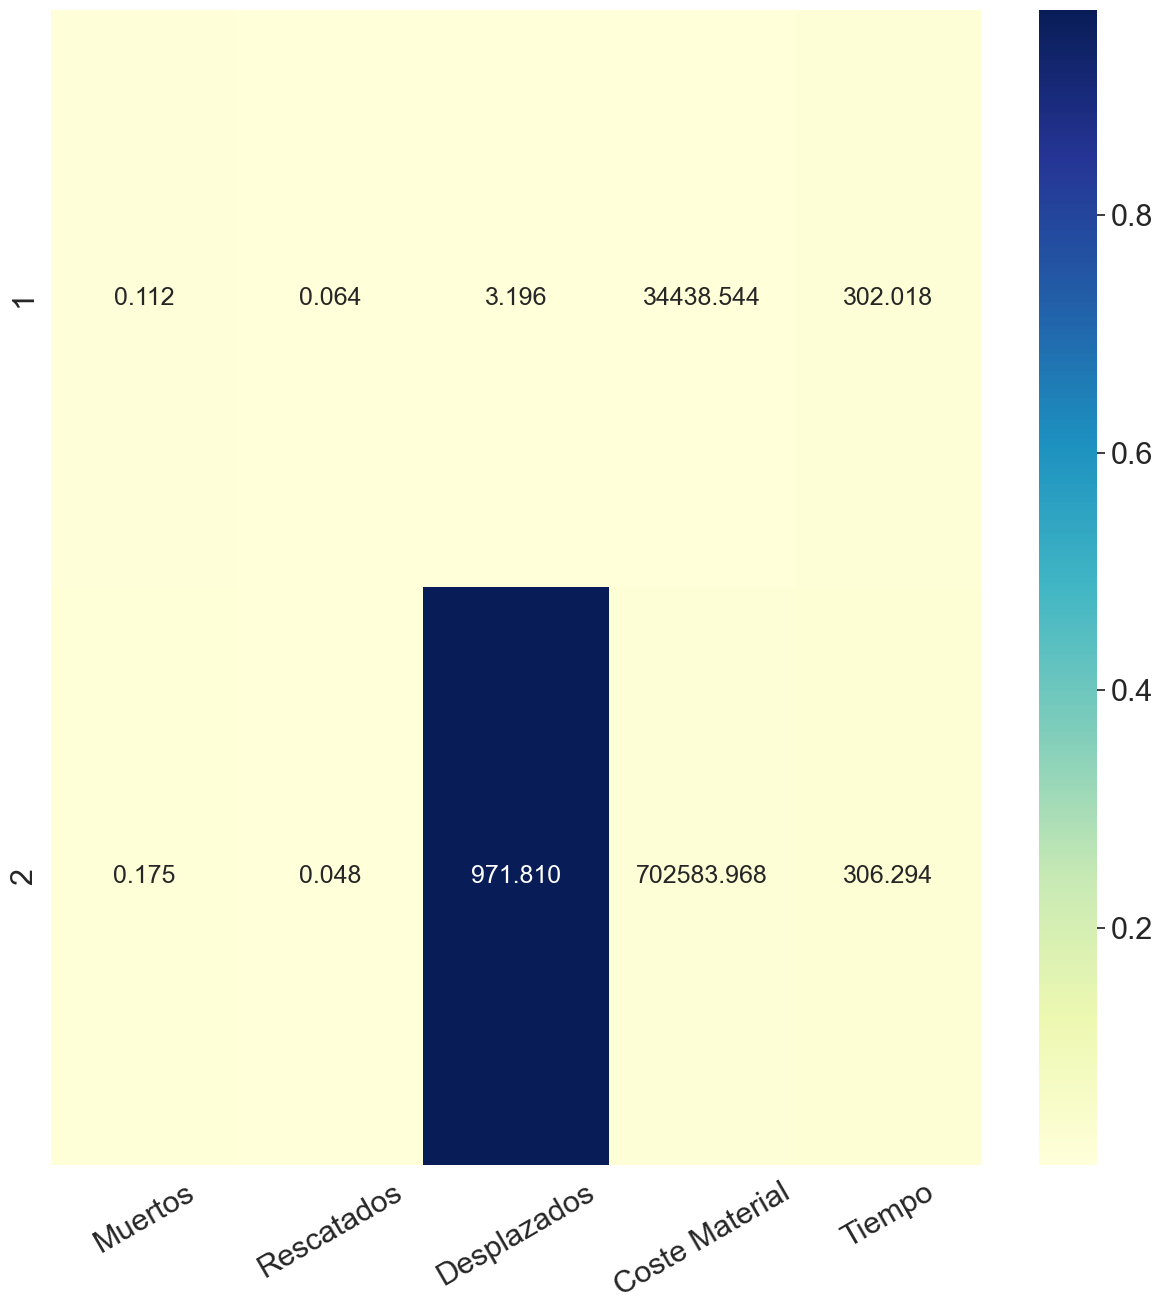

In [166]:
X = datos.loc[(datos['Day_Of_Week']!='Saturday') & (datos['Day_Of_Week']!='Sunday')]
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]

X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=2, n_init=5, random_state=2020)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

#'''
print("---------- Heatmap de centroides...")
plt.figure()
centers.index += 1
plt.figure()
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
plt.xticks(rotation=30)
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)

### Mean Shift

In [42]:
X_normal = caso1

In [43]:
    meanshift = MeanShift(bandwidth=0.3)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 0.7000000000000001: 1.67 segundos, Calinski-Harabasz Index: 1576.331, Silhouette Coefficient: 0.93577
Tamaño de cada cluster:
0:  2193 (98.52%)
1:    26 ( 1.17%)
2:     4 ( 0.18%)
3:     1 ( 0.04%)
4:     1 ( 0.04%)
5:     1 ( 0.04%)


Tamaño de cada cluster:
0:  2193 (98.52%)
1:    26 ( 1.17%)
2:     4 ( 0.18%)
3:     1 ( 0.04%)
5:     1 ( 0.04%)
4:     1 ( 0.04%)


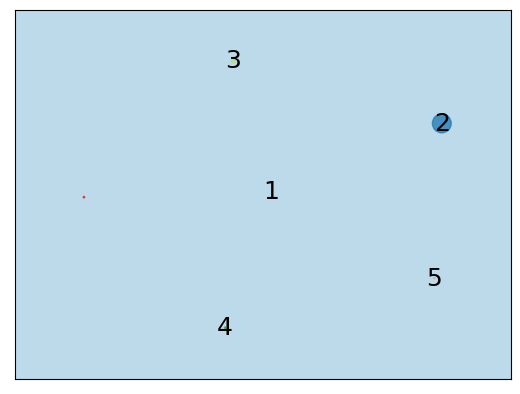

In [181]:
X = datos.loc[datos['Arrival_Time']>360]
X=X.rename(columns={"Civilian_Casualties": "Muertos", "Count_of_Persons_Rescued": "Rescatados", "Estimated_Number_Of_Persons_Displaced": "Desplazados", "Estimated_Dollar_Loss": "Coste Material", "Arrival_Time": "Tiempo"})
usadas = ["Muertos", "Rescatados", "Desplazados", "Coste Material", "Tiempo"]
X = X[usadas]
X_normal = X.apply(norm_to_zero_one)
k_means = MeanShift(bandwidth=0.3)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal)

clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.items():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

size = size.sort_index()

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())


mds = MDS(random_state=123456)
centers_mds = mds.fit_transform(centers)
colors = sns.color_palette(palette='Paired', n_colors=6, desat=None)
plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size**1.6, alpha=0.75, c=colors) # mejor si se usa weights de 'DB090' para size
for i in range(k):
    plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
xl,xr = plt.xlim()
yl,yr = plt.ylim()
plt.xlim(xl-(xr-xl)*0.13,xr+(xr-xl)*0.13)
plt.ylim(yl-(yr-yl)*0.13,yr+(yr-yl)*0.13)
plt.xticks([])
plt.yticks([])
fig.set_size_inches(15,15)

In [44]:
X_normal = caso1c

In [45]:
    meanshift = MeanShift(bandwidth=0.3)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 0.7000000000000001: 28.63 segundos, Calinski-Harabasz Index: 1197.317, Silhouette Coefficient: 0.73675
Tamaño de cada cluster:
0:  8848 (98.44%)
1:   135 ( 1.50%)
2:     3 ( 0.03%)
3:     1 ( 0.01%)
4:     1 ( 0.01%)


In [151]:
X_normal = caso2

In [153]:

    meanshift = MeanShift(bandwidth=0.5)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 8: 2.72 segundos, Calinski-Harabasz Index: 1999.335, Silhouette Coefficient: 0.87283
Tamaño de cada cluster:
0:  2516 (97.94%)
1:    51 ( 1.99%)
2:     2 ( 0.08%)


In [154]:
X_normal = caso2c

In [155]:

    meanshift = MeanShift(bandwidth=0.5)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 8: 9.78 segundos, Calinski-Harabasz Index: 17977.605, Silhouette Coefficient: 0.97307
Tamaño de cada cluster:
0:  8528 (98.65%)
1:   114 ( 1.32%)
2:     1 ( 0.01%)
3:     1 ( 0.01%)
4:     1 ( 0.01%)


In [50]:
X_normal = caso3

In [51]:
    meanshift = MeanShift(bandwidth=0.3)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 0.7000000000000001: 4.03 segundos, Calinski-Harabasz Index: 818.370, Silhouette Coefficient: 0.83744
Tamaño de cada cluster:
0:  3260 (98.61%)
1:    40 ( 1.21%)
2:     4 ( 0.12%)
3:     1 ( 0.03%)
4:     1 ( 0.03%)


In [52]:
X_normal = caso3c

In [53]:
    meanshift = MeanShift(bandwidth=0.3)
    # Tiempo
    t = time.time()
    cluster_predict = meanshift.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 0.7000000000000001: 8.75 segundos, Calinski-Harabasz Index: 18118.217, Silhouette Coefficient: 0.96680
Tamaño de cada cluster:
0:  7778 (98.36%)
1:   125 ( 1.58%)
2:     2 ( 0.03%)
3:     1 ( 0.01%)
4:     1 ( 0.01%)
5:     1 ( 0.01%)


## Aglomerativo: Análisis paramétrico

In [54]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=5, linkage="ward")

In [193]:
X_normal = caso1

In [194]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.10 segundos, Calinski-Harabasz Index: 4179.519, Silhouette Coefficient: 0.95524
Tamaño de cada cluster:
0:  2200 (98.83%)
1:    26 ( 1.17%)
 Números de Clusters 3: 0.09 segundos, Calinski-Harabasz Index: 4474.794, Silhouette Coefficient: 0.88865
Tamaño de cada cluster:
0:   178 ( 8.00%)
1:    26 ( 1.17%)
2:  2022 (90.84%)
 Números de Clusters 4: 0.11 segundos, Calinski-Harabasz Index: 3863.115, Silhouette Coefficient: 0.88269
Tamaño de cada cluster:
0:  2022 (90.84%)
1:   141 ( 6.33%)
2:    37 ( 1.66%)
3:    26 ( 1.17%)
 Números de Clusters 5: 0.10 segundos, Calinski-Harabasz Index: 3543.985, Silhouette Coefficient: 0.88564
Tamaño de cada cluster:
0:  2021 (90.79%)
1:   141 ( 6.33%)
2:    37 ( 1.66%)
3:    26 ( 1.17%)
4:     1 ( 0.04%)
 Números de Clusters 6: 0.10 segundos, Calinski-Harabasz Index: 3589.874, Silhouette Coefficient: 0.88859
Tamaño de cada cluster:
0:    37 ( 1.66%)
1:   141 ( 6.33%)
2:  2020 (90.75%)
3:    26 ( 1.17%)
4:     1 ( 0.04%)
5:     1

---------- Dendrogramas...
 Números de Clusters 3: 2.25 segundos, Calinski-Harabasz Index: 133578.694, Silhouette Coefficient: 0.98915
Tamaño de cada cluster:
0:  8528 (98.65%)
1:    10 ( 0.12%)
2:   107 ( 1.24%)


NameError: name 'caso' is not defined

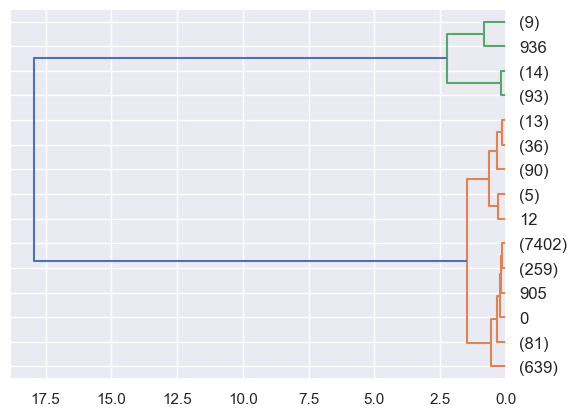

In [214]:
print("---------- Dendrogramas...")
ac = AgglomerativeClustering(n_clusters=3, linkage="ward")
# Tiempo
t = time.time()
cluster_predict = ac.fit_predict(X_normal)
tiempo = time.time() - t
print(" Números de Clusters " + str(3)+ ": {:.2f} segundos, ".format(tiempo), end='')

# Calinski-Harabasz
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
metric_CH = -1
# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

# Silhouette
metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))
metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
metric_SC_samples = -1
# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

# Tamaño de cluster
print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()

size = size.sort_index()
tam = []
n = []
for num,i in size.iteritems():
    n.append(num)
    tam.append(i)
    print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

k = len(size)

# Centros
X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
cluster_centers = X_normal_alg.groupby("cluster").mean()
centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

# se añade la asignación de clusters como columna a X
X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

sns.set_theme(color_codes=True)
X_normal = preprocessing.normalize(X_alg, norm='l2')
linkage_array = hierarchy.ward(X_normal)
p = 15
hierarchy.dendrogram(linkage_array, orientation='left', p=p, truncate_mode='lastp')
plt.savefig("img/" + caso + "/" + alg + "/dendrograma_" + str(p) + ".pdf")
plt.clf()
    
X_normal = pd.DataFrame(X_normal,index=X_alg.index,columns=usadas)
sns.clustermap(X_normal, method='ward', col_cluster=False, figsize=(20,10), cmap="YlGnBu", yticklabels=False)

plt.clf()

In [196]:
X_normal = caso1c

In [197]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 2.51 segundos, Calinski-Harabasz Index: 5994.166, Silhouette Coefficient: 0.50182
Tamaño de cada cluster:
0:  4738 (52.71%)
1:  4250 (47.29%)
 Números de Clusters 3: 2.52 segundos, Calinski-Harabasz Index: 12443.740, Silhouette Coefficient: 0.54254
Tamaño de cada cluster:
0:  4250 (47.29%)
1:  4596 (51.13%)
2:   142 ( 1.58%)
 Números de Clusters 4: 2.44 segundos, Calinski-Harabasz Index: 13490.468, Silhouette Coefficient: 0.44633
Tamaño de cada cluster:
0:  4596 (51.13%)
1:  1974 (21.96%)
2:   142 ( 1.58%)
3:  2276 (25.32%)
 Números de Clusters 5: 2.46 segundos, Calinski-Harabasz Index: 14131.571, Silhouette Coefficient: 0.42644
Tamaño de cada cluster:
0:  1974 (21.96%)
1:  3372 (37.52%)
2:   142 ( 1.58%)
3:  2276 (25.32%)
4:  1224 (13.62%)
 Números de Clusters 6: 2.49 segundos, Calinski-Harabasz Index: 15072.943, Silhouette Coefficient: 0.42879
Tamaño de cada cluster:
0:  3372 (37.52%)
1:   605 ( 6.73%)
2:   142 ( 1.58%)
3:  2276 (25.32%)
4:  1224 (13.62%)
5:  

---------- Dendrogramas...


NameError: name 'caso' is not defined

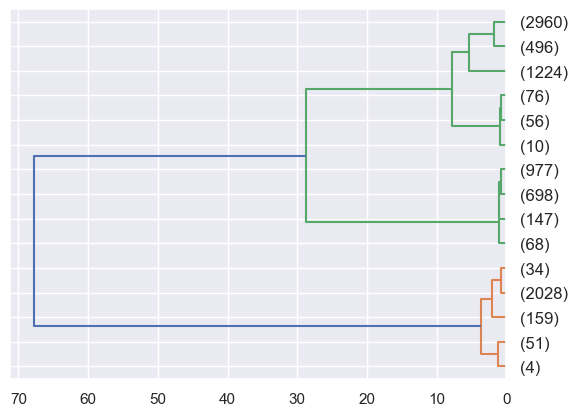

In [205]:
print("---------- Dendrogramas...")
    
sns.set_theme(color_codes=True)
X_normal = preprocessing.normalize(X_alg, norm='l2')
linkage_array = hierarchy.ward(X_normal)
p = 15
hierarchy.dendrogram(linkage_array, orientation='left', p=p, truncate_mode='lastp')
plt.savefig("img/" + caso + "/" +"/dendrograma_" + str(p) + ".pdf")
plt.clf()
    
X_normal = pd.DataFrame(X_normal,index=X_alg.index,columns=usadas)
sns.clustermap(X_normal, method='ward', col_cluster=False, figsize=(20,10), cmap="YlGnBu", yticklabels=False)

plt.clf()

In [215]:
X_normal = caso2

In [216]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.14 segundos, Calinski-Harabasz Index: 3698.354, Silhouette Coefficient: 0.88723
Tamaño de cada cluster:
0:  2519 (98.05%)
1:    50 ( 1.95%)
 Números de Clusters 3: 0.13 segundos, Calinski-Harabasz Index: 2971.503, Silhouette Coefficient: 0.44021
Tamaño de cada cluster:
0:  1971 (76.72%)
1:    50 ( 1.95%)
2:   548 (21.33%)
 Números de Clusters 4: 0.14 segundos, Calinski-Harabasz Index: 2988.337, Silhouette Coefficient: 0.51063
Tamaño de cada cluster:
0:  1826 (71.08%)
1:   145 ( 5.64%)
2:   548 (21.33%)
3:    50 ( 1.95%)
 Números de Clusters 5: 0.13 segundos, Calinski-Harabasz Index: 2788.632, Silhouette Coefficient: 0.43886
Tamaño de cada cluster:
0:   145 ( 5.64%)
1:  1388 (54.03%)
2:   548 (21.33%)
3:    50 ( 1.95%)
4:   438 (17.05%)
 Números de Clusters 6: 0.13 segundos, Calinski-Harabasz Index: 2764.009, Silhouette Coefficient: 0.44624
Tamaño de cada cluster:
0:  1388 (54.03%)
1:   138 ( 5.37%)
2:   548 (21.33%)
3:    50 ( 1.95%)
4:   438 (17.05%)
5:     7

---------- Dendrogramas...
 Números de Clusters 3: 0.13 segundos, Calinski-Harabasz Index: 3698.354, Silhouette Coefficient: 0.88723
Tamaño de cada cluster:
0:  2519 (98.05%)
1:    50 ( 1.95%)


NameError: name 'caso' is not defined

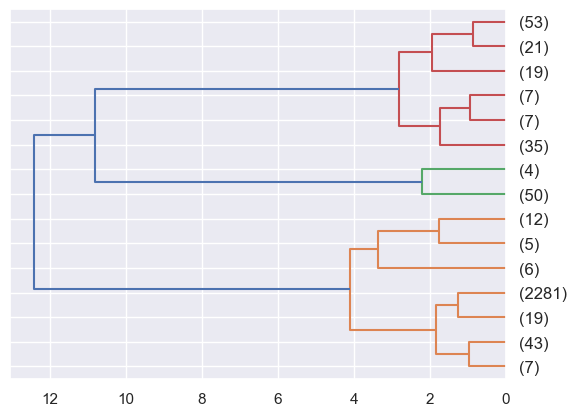

In [217]:
ac = AgglomerativeClustering(n_clusters=2, linkage="ward")
# Tiempo
t = time.time()
cluster_predict = ac.fit_predict(X_normal)
tiempo = time.time() - t
print(" Números de Clusters " + str(3)+ ": {:.2f} segundos, ".format(tiempo), end='')

# Calinski-Harabasz
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
metric_CH = -1
# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

# Silhouette
metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))
metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
metric_SC_samples = -1
# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

# Tamaño de cluster
print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()

size = size.sort_index()
tam = []
n = []
for num,i in size.iteritems():
    n.append(num)
    tam.append(i)
    print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

k = len(size)

# Centros
X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
cluster_centers = X_normal_alg.groupby("cluster").mean()
centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

# se añade la asignación de clusters como columna a X
X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

sns.set_theme(color_codes=True)
X_normal = preprocessing.normalize(X_alg, norm='l2')
linkage_array = hierarchy.ward(X_normal)
p = 15
hierarchy.dendrogram(linkage_array, orientation='left', p=p, truncate_mode='lastp')
plt.savefig("img/" + caso + "/" + alg + "/dendrograma_" + str(p) + ".pdf")
plt.clf()
    
X_normal = pd.DataFrame(X_normal,index=X_alg.index,columns=usadas)
sns.clustermap(X_normal, method='ward', col_cluster=False, figsize=(20,10), cmap="YlGnBu", yticklabels=False)

plt.clf()

In [209]:
X_normal = caso2c

In [210]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 2.17 segundos, Calinski-Harabasz Index: 56105.259, Silhouette Coefficient: 0.97258
Tamaño de cada cluster:
0:  8528 (98.65%)
1:   117 ( 1.35%)
 Números de Clusters 3: 2.15 segundos, Calinski-Harabasz Index: 44410.537, Silhouette Coefficient: 0.85467
Tamaño de cada cluster:
0:   117 ( 1.35%)
1:   785 ( 9.08%)
2:  7743 (89.57%)
 Números de Clusters 4: 2.20 segundos, Calinski-Harabasz Index: 36045.784, Silhouette Coefficient: 0.85499
Tamaño de cada cluster:
0:   785 ( 9.08%)
1:    10 ( 0.12%)
2:  7743 (89.57%)
3:   107 ( 1.24%)
 Números de Clusters 5: 2.17 segundos, Calinski-Harabasz Index: 32980.632, Silhouette Coefficient: 0.84338
Tamaño de cada cluster:
0:  7743 (89.57%)
1:    10 ( 0.12%)
2:   145 ( 1.68%)
3:   107 ( 1.24%)
4:   640 ( 7.40%)
 Números de Clusters 6: 2.13 segundos, Calinski-Harabasz Index: 31669.956, Silhouette Coefficient: 0.86101
Tamaño de cada cluster:
0:   238 ( 2.75%)
1:    10 ( 0.12%)
2:  7505 (86.81%)
3:   107 ( 1.24%)
4:   640 ( 7.40%)
5: 

In [218]:
X_normal = caso3

In [219]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 0.25 segundos, Calinski-Harabasz Index: 2655.632, Silhouette Coefficient: 0.87125
Tamaño de cada cluster:
0:  3267 (98.82%)
1:    39 ( 1.18%)
 Números de Clusters 3: 0.25 segundos, Calinski-Harabasz Index: 3101.744, Silhouette Coefficient: 0.43564
Tamaño de cada cluster:
0:  1792 (54.20%)
1:    39 ( 1.18%)
2:  1475 (44.62%)
 Números de Clusters 4: 0.24 segundos, Calinski-Harabasz Index: 2926.608, Silhouette Coefficient: 0.38083
Tamaño de cada cluster:
0:  1475 (44.62%)
1:  1217 (36.81%)
2:   575 (17.39%)
3:    39 ( 1.18%)
 Números de Clusters 5: 0.25 segundos, Calinski-Harabasz Index: 3190.846, Silhouette Coefficient: 0.45088
Tamaño de cada cluster:
0:   575 (17.39%)
1:  1257 (38.02%)
2:   218 ( 6.59%)
3:    39 ( 1.18%)
4:  1217 (36.81%)
 Números de Clusters 6: 0.25 segundos, Calinski-Harabasz Index: 2950.354, Silhouette Coefficient: 0.44922
Tamaño de cada cluster:
0:   218 ( 6.59%)
1:  1257 (38.02%)
2:   487 (14.73%)
3:    39 ( 1.18%)
4:  1217 (36.81%)
5:    88

---------- Dendrogramas...
 Números de Clusters 3: 0.24 segundos, Calinski-Harabasz Index: 2655.632, Silhouette Coefficient: 0.87125
Tamaño de cada cluster:
0:  3267 (98.82%)
1:    39 ( 1.18%)


NameError: name 'caso' is not defined

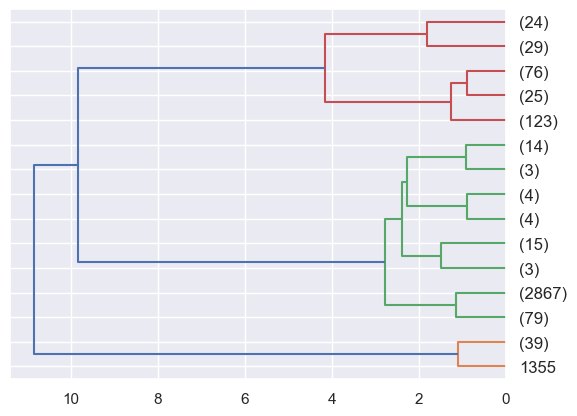

In [220]:
print("---------- Dendrogramas...")
ac = AgglomerativeClustering(n_clusters=2, linkage="ward")
# Tiempo
t = time.time()
cluster_predict = ac.fit_predict(X_normal)
tiempo = time.time() - t
print(" Números de Clusters " + str(3)+ ": {:.2f} segundos, ".format(tiempo), end='')

# Calinski-Harabasz
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
metric_CH = -1
# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

# Silhouette
metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))
metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
metric_SC_samples = -1
# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

# Tamaño de cluster
print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()

size = size.sort_index()
tam = []
n = []
for num,i in size.iteritems():
    n.append(num)
    tam.append(i)
    print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

k = len(size)

# Centros
X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
cluster_centers = X_normal_alg.groupby("cluster").mean()
centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

# se añade la asignación de clusters como columna a X
X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

sns.set_theme(color_codes=True)
X_normal = preprocessing.normalize(X_alg, norm='l2')
linkage_array = hierarchy.ward(X_normal)
p = 15
hierarchy.dendrogram(linkage_array, orientation='left', p=p, truncate_mode='lastp')
plt.savefig("img/" + caso + "/" + alg + "/dendrograma_" + str(p) + ".pdf")
plt.clf()
    
X_normal = pd.DataFrame(X_normal,index=X_alg.index,columns=usadas)
sns.clustermap(X_normal, method='ward', col_cluster=False, figsize=(20,10), cmap="YlGnBu", yticklabels=False)

plt.clf()

In [65]:
X_normal = caso3c

In [66]:
for ncs in range(2, 9):
    ac = AgglomerativeClustering(n_clusters=ncs, linkage="ward")
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 2: 1.88 segundos, Calinski-Harabasz Index: 62414.515, Silhouette Coefficient: 0.97420
Tamaño de cada cluster:
0:  7787 (98.47%)
1:   121 ( 1.53%)
 Números de Clusters 3: 1.93 segundos, Calinski-Harabasz Index: 47413.094, Silhouette Coefficient: 0.85384
Tamaño de cada cluster:
0:  7136 (90.24%)
1:   121 ( 1.53%)
2:   651 ( 8.23%)
 Números de Clusters 4: 1.91 segundos, Calinski-Harabasz Index: 41779.831, Silhouette Coefficient: 0.86548
Tamaño de cada cluster:
0:   651 ( 8.23%)
1:   121 ( 1.53%)
2:  7108 (89.88%)
3:    28 ( 0.35%)
 Números de Clusters 5: 1.87 segundos, Calinski-Harabasz Index: 37842.701, Silhouette Coefficient: 0.85544
Tamaño de cada cluster:
0:   121 ( 1.53%)
1:   524 ( 6.63%)
2:  7108 (89.88%)
3:    28 ( 0.35%)
4:   127 ( 1.61%)
 Números de Clusters 6: 1.86 segundos, Calinski-Harabasz Index: 36157.656, Silhouette Coefficient: 0.85560
Tamaño de cada cluster:
0:   524 ( 6.63%)
1:   127 ( 1.61%)
2:  7108 (89.88%)
3:    28 ( 0.35%)
4:   120 ( 1.52%)
5: 

## BIRCH:

In [120]:
X_normal = caso1

In [121]:
    ac = Birch(branching_factor=25, threshold=0.1, n_clusters=3)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.03 segundos, Calinski-Harabasz Index: 2341.273, Silhouette Coefficient: 0.95538
Tamaño de cada cluster:
0:  2199 (98.79%)
1:    26 ( 1.17%)
2:     1 ( 0.04%)


In [118]:
X_normal = caso1c

In [119]:
    ac = Birch(branching_factor=15, threshold=0.25, n_clusters=6)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.12 segundos, Calinski-Harabasz Index: 5414.296, Silhouette Coefficient: 0.55060
Tamaño de cada cluster:
0:     1 ( 0.01%)
1:   139 ( 1.55%)
2:  5457 (60.71%)
3:  3383 (37.64%)
4:     7 ( 0.08%)
5:     1 ( 0.01%)


In [122]:
X_normal = caso2

In [123]:
    ac = Birch(branching_factor=25, threshold=0.1, n_clusters=5)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.03 segundos, Calinski-Harabasz Index: 1413.593, Silhouette Coefficient: 0.73491
Tamaño de cada cluster:
0:  2491 (96.96%)
1:    12 ( 0.47%)
2:    10 ( 0.39%)
3:    50 ( 1.95%)
4:     6 ( 0.23%)


In [124]:
X_normal = caso2c

In [125]:
    ac = Birch(branching_factor=25, threshold=0.1, n_clusters=4)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.11 segundos, Calinski-Harabasz Index: 21270.086, Silhouette Coefficient: 0.97230
Tamaño de cada cluster:
0:   109 ( 1.26%)
1:  8534 (98.72%)
2:     1 ( 0.01%)
3:     1 ( 0.01%)


In [126]:
X_normal = caso3

In [127]:
    ac = Birch(branching_factor=25, threshold=0.1, n_clusters=4)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.04 segundos, Calinski-Harabasz Index: 1042.027, Silhouette Coefficient: 0.83749
Tamaño de cada cluster:
0:  3262 (98.67%)
1:    39 ( 1.18%)
2:     4 ( 0.12%)
3:     1 ( 0.03%)


In [128]:
X_normal = caso3c

In [130]:
    ac = Birch(branching_factor=15, threshold=0.2, n_clusters=5)
    # Tiempo
    t = time.time()
    cluster_predict = ac.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.10 segundos, Calinski-Harabasz Index: 20221.100, Silhouette Coefficient: 0.97310
Tamaño de cada cluster:
0:  7780 (98.38%)
1:     1 ( 0.01%)
2:     1 ( 0.01%)
3:     1 ( 0.01%)
4:   125 ( 1.58%)


## DBSCAN

In [131]:
X_normal = caso1

In [133]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.07 segundos, Calinski-Harabasz Index: 1925.762, Silhouette Coefficient: 0.89461
Tamaño de cada cluster:
-1:    24 ( 1.08%)
0:  2014 (90.48%)
1:   141 ( 6.33%)
2:    24 ( 1.08%)
3:    23 ( 1.03%)


In [134]:
X_normal = caso1c

In [135]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 1.28 segundos, Calinski-Harabasz Index: 2305.262, Silhouette Coefficient: 0.70854
Tamaño de cada cluster:
-1:    22 ( 0.24%)
0:  8837 (98.32%)
1:   129 ( 1.44%)


In [156]:
X_normal = caso2

In [158]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 8: 0.12 segundos, Calinski-Harabasz Index: 1172.381, Silhouette Coefficient: 0.55019
Tamaño de cada cluster:
-1:    31 ( 1.21%)
0:   117 ( 4.55%)
1:  2362 (91.94%)
2:    45 ( 1.75%)
3:    14 ( 0.54%)


In [138]:
X_normal = caso2c

In [139]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.96 segundos, Calinski-Harabasz Index: 28304.643, Silhouette Coefficient: 0.96475
Tamaño de cada cluster:
-1:    10 ( 0.12%)
0:  8528 (98.65%)
1:   107 ( 1.24%)


In [140]:
X_normal = caso3

In [141]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.20 segundos, Calinski-Harabasz Index: 1298.160, Silhouette Coefficient: 0.82537
Tamaño de cada cluster:
-1:    17 ( 0.51%)
0:  3254 (98.43%)
1:    35 ( 1.06%)


In [142]:
X_normal = caso3c

In [143]:
    dbscan = DBSCAN(eps=0.14, min_samples=10)
    # Tiempo
    t = time.time()
    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    print(" Números de Clusters " + str(ncs)+ ": {:.2f} segundos, ".format(tiempo), end='')

    # Calinski-Harabasz
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    metric_CH = -1
    # Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
    # Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
    muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0

    # Silhouette
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X_normal)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    metric_SC_samples = -1
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,columns=['cluster'])

    # Tamaño de cluster
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()

    size = size.sort_index()
    tam = []
    n = []
    for num,i in size.iteritems():
        n.append(num)
        tam.append(i)
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

    k = len(size)

    # Centros
    X_normal_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)
    cluster_centers = X_normal_alg.groupby("cluster").mean()
    centers = pd.DataFrame(cluster_centers, columns=list(X_normal))

    # se añade la asignación de clusters como columna a X
    X_alg = pd.concat([pd.DataFrame(X_normal), clusters], axis=1)

 Números de Clusters 6: 0.89 segundos, Calinski-Harabasz Index: 30825.851, Silhouette Coefficient: 0.96649
Tamaño de cada cluster:
-1:     9 ( 0.11%)
0:  7781 (98.39%)
1:   118 ( 1.49%)
